In [ ]:
!pip install plotly tfa-nightly tqdm numpy matplotlib

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Subtract, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers
import tensorflow_addons as tfa
from tqdm.notebook import tqdm


In [ ]:
plt.rcParams['figure.figsize'] = (9, 5)

In [ ]:
noise_std_train = (0, 55)
noise_std_val = 30
batch_size = 32
im_size = 128

# Code to generate a dataset that contains images with vertical lines and others with horizontal lines
def generate_images(im_size=128, prop_bands=0.2):
    while True:
        im = np.zeros((im_size, im_size), dtype=np.float64)
        band_locations = np.random.randint(0, im_size, int(prop_bands * im_size))
        p = np.random.uniform() # between 0 and 1
        if p >= 0.5:
          im[:, band_locations] = 1.0
        else:
          im[band_locations, :] = 1.0
        yield im

# Code to generate a dataset that contains images with vertical lines and horizontal lines
#def generate_images(im_size=128, prop_bands=0.2):
#    while True:
#        im = np.zeros((im_size, im_size), dtype=np.float64)
#        band_locations = np.random.randint(0, im_size, int((prop_bands * im_size)/2))
#        im[:, band_locations] = 1.0
#        band_locations = np.random.randint(0, im_size, int((prop_bands * im_size)/2))
#        im[band_locations, :] = 1.0
#        yield im

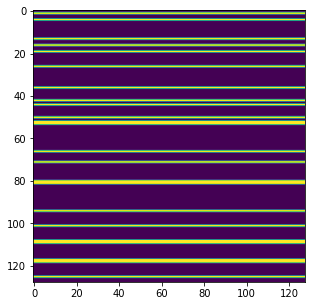

In [ ]:
plt.figure()
plt.imshow(next(generate_images()))

In [ ]:
vert_hor_ds = tf.data.Dataset.from_generator(
    generate_images, 
    tf.float32, 
    tf.TensorShape([im_size, im_size]),
    args=(im_size, 0.2)
).map(lambda x: x[..., None], num_parallel_calls=tf.data.experimental.AUTOTUNE)

def add_noise_function(noise_std_range):
    if not isinstance(noise_std_range, tuple):
        noise_std_range = (noise_std_range, noise_std_range)
    def add_noise(image):
        noise_std = tf.random.uniform(
            (1,),
            minval=noise_std_range[0],
            maxval=noise_std_range[1],
        )
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=noise_std/255, dtype=tf.float32)
        return image + noise
    return add_noise

add_noise_train = add_noise_function(noise_std_train)
add_noise_val = add_noise_function(noise_std_val)

vert_hor_ds_train = vert_hor_ds.map(
    lambda patch: (add_noise_train(patch), patch),
    num_parallel_calls=tf.data.experimental.AUTOTUNE,
).batch(batch_size).repeat().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

vert_hor_ds_val = vert_hor_ds.map(
    lambda patch: (add_noise_val(patch), patch),
    num_parallel_calls=tf.data.experimental.AUTOTUNE,
).batch(batch_size).repeat().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

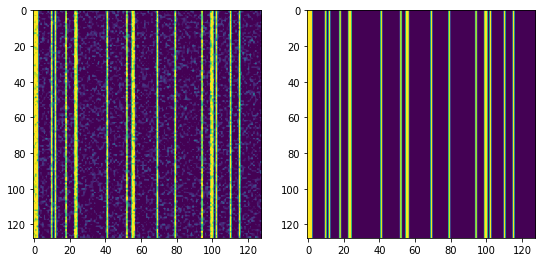

In [ ]:
fig, axs = plt.subplots(1, 2)
training_example = next(iter(vert_hor_ds_train))
axs[0].imshow(np.squeeze(training_example[0][0]), vmin=0, vmax=1)
axs[1].imshow(np.squeeze(training_example[1][0]), vmin=0, vmax=1)

In [ ]:
class SingularValuesConstraintHard(tf.keras.constraints.Constraint):
  """Hard thresholding of singular values"""

  def __init__(self, thr_value = 0.3, axis = 0):
    self.thr_value = thr_value
    self.axis = axis

  def __call__(self, w):
    s, u, v = tf.linalg.svd(w)
    thr = self.thr_value*s[0]
    s=tf.where(s < thr, 0.0, s)
    w=tf.matmul(u,tf.matmul(tf.linalg.diag(s),v,adjoint_b=True))
    return w

  def get_config(self):
    return {'thr_value': self.thr_value, 'axis': self.axis}


In [ ]:
class SingularValuesConstraintSoft(tf.keras.constraints.Constraint):
  """Soft thresholding of singular values"""

  def __init__(self, thr_value = 0.3, axis = 0, ff_size = 25, n_filters = 16):
    self.thr_value = thr_value
    self.axis = axis
    self.ff_size = ff_size
    self.n_filters = n_filters

  def __call__(self, w):
    w_reshaped = tf.reshape(w, [-1, self.ff_size, self.n_filters])
    s, u, v = tf.linalg.svd(w_reshaped)
    thr = self.thr_value*s[0]
    s=tf.where(abs(s) < thr, 0.0, sign(s)*(abs(s)-thr))
    w_reshaped=tf.matmul(u,tf.matmul(tf.linalg.diag(s),v,adjoint_b=True))
    w = tf.reshape(w_reshaped, [5, 5, 1, 16])
    return w

  def get_config(self):
    return {'thr_value': self.thr_value, 'axis': self.axis}


In [ ]:
tf.keras.initializers.GlorotUniform(seed=None)

class LinearFiltersCombine(Model):
  def __init__(self, n_filters=1, drop_rate=0., **kwargs):
    super(LinearFiltersCombine, self).__init__(**kwargs)
    #constraint = SingularValuesConstraintSoft(thr_value = 0.3, axis = [0, 1, 2])
    initializer = tf.keras.initializers.Constant(1/25)
    self.decompositionFixed = Conv2D(
      int(n_filters/2),
      5,
      padding='valid',
      activation='linear',
      #kernel_initializer=initializer,
      #kernel_constraint=constraint,
      use_bias=False,
      trainable = False
    )
    self.decompositionTrain = Conv2D(
      int(n_filters/2),
      5,
      padding='valid',
      activation='linear',
      kernel_initializer=initializer,
      #kernel_constraint=constraint,
      use_bias=False,
    )
    self.drop = Dropout(drop_rate, noise_shape=(batch_size, 1, 1, int(n_filters/2))) # omits certain neurons
    self.linear_combination1 = Conv2D(1, 1, use_bias=True)
    self.linear_combination2 = Conv2D(1, 1, use_bias=True)
    self.paddings = tf.constant([(0,0), (2, 2), (2, 2), (0, 0)])
  
  def call(self, inputs):
    im_padded = tf.pad(inputs, self.paddings, 'SYMMETRIC')
    im_conv1 = self.decompositionFixed(im_padded)
    im_conv2 = self.decompositionTrain(im_padded)
    im_drop1 = self.drop(im_conv1)
    im_drop2 = self.drop(im_conv2)
    res = self.linear_combination1(im_drop1)+self.linear_combination2(im_drop2)
    return res

base_f = 4
model = LinearFiltersCombine(n_filters=base_f**2, drop_rate=0.)
  # model.build()

def tf_psnr(y_true, y_pred):
  return tf.image.psnr(y_true, y_pred, 1.0)

def tf_ssim(y_true, y_pred):
  return tf.image.ssim(y_true, y_pred, 1.0)

model.compile(loss='mse', optimizer=Adam(lr=1e-3), metrics=[tf_psnr, tf_ssim])

In [ ]:
model(tf.zeros([1, 32, 32, 1])).shape

TensorShape([1, 32, 32, 1])

In [ ]:
tqdm_cb = tfa.callbacks.TQDMProgressBar(metrics_format="{name}: {value:e}")
tqdm_cb.tqdm = tqdm

In [ ]:
model.fit(
    vert_hor_ds_train, 
    steps_per_epoch=200, 
    epochs=15,
    validation_data=vert_hor_ds_val,
    validation_steps=1,
    verbose=0,
    callbacks=[tqdm_cb,],
    shuffle=False,
)

Epoch 1/15



Epoch 2/15



Epoch 3/15



Epoch 4/15



Epoch 5/15



Epoch 6/15



Epoch 7/15



Epoch 8/15



Epoch 9/15



Epoch 10/15



Epoch 11/15



Epoch 12/15



Epoch 13/15



Epoch 14/15



Epoch 15/15


In [ ]:
metrics = model.evaluate(vert_hor_ds_val, steps=300)

300/300 [==============================] - 6s 19ms/step - loss: 0.0049 - tf_psnr: 23.1020 - tf_ssim: 0.7743


Model: "linear_filters_combine_1"
________________________________________________________________________________________________________________________
Layer (type)                                          Output Shape                                    Param #           
conv2d_4 (Conv2D)                                     multiple                                        200               
________________________________________________________________________________________________________________________
conv2d_5 (Conv2D)                                     multiple                                        200               
________________________________________________________________________________________________________________________
dropout_1 (Dropout)                                   multiple                                        0                 
_______________________________________________________________________________________________________________________

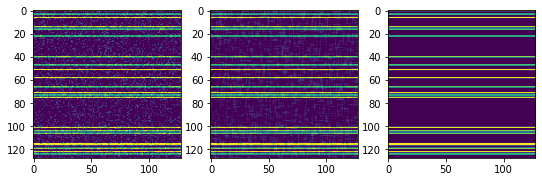

In [ ]:
print(model.summary(line_length=120))

example_val = next(iter(vert_hor_ds_val))
denoised_image = model.predict_on_batch(example_val[0])

fig, axs = plt.subplots(1, 3)
axs[0].imshow(np.squeeze(example_val[0][0]), vmin=0, vmax=1)
axs[1].imshow(np.squeeze(denoised_image[0]), vmin=0, vmax=1)
axs[2].imshow(np.squeeze(example_val[1][0]), vmin=0, vmax=1)

## Filters visualization

In [ ]:
decomp_kernels_fix = model.layers[0].get_weights()[0]
decomp_kernels_train = model.layers[1].get_weights()[0]
recomb_kernels_1 = model.layers[3].get_weights()[0]
recomb_kernels_2 = model.layers[4].get_weights()[0]

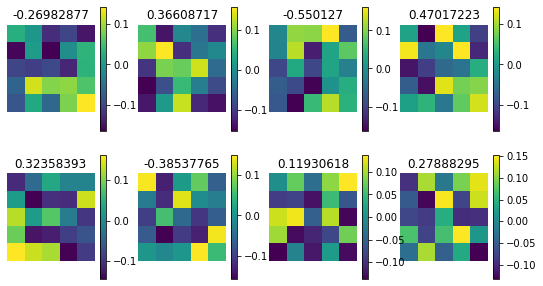

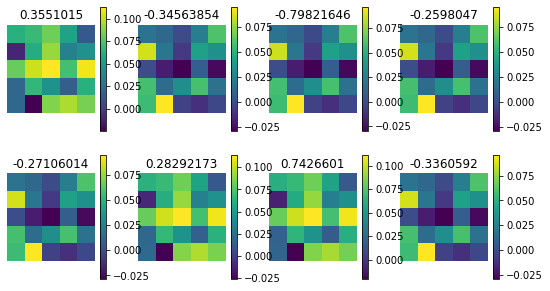

In [ ]:
fig, axs = plt.subplots(int(base_f/2), base_f, sharex=True, sharey=True)
for i in range(int(base_f/2)):
  for j in range(base_f):
    im = axs[i, j].imshow(np.squeeze(decomp_kernels_fix[..., 0, i * base_f + j]))
    axs[i, j].axis('off')
    axs[i, j].set_title(np.squeeze(recomb_kernels_1[..., i * base_f + j, 0]))
    fig.colorbar(im, ax=axs[i, j])

fig, axs = plt.subplots(int(base_f/2), base_f, sharex=True, sharey=True)
for i in range(int(base_f/2)):
  for j in range(base_f):
    im = axs[i, j].imshow(np.squeeze(decomp_kernels_train[..., 0, i * base_f + j]))
    axs[i, j].axis('off')
    axs[i, j].set_title(np.squeeze(recomb_kernels_2[..., i * base_f + j, 0]))
    fig.colorbar(im, ax=axs[i, j])

    

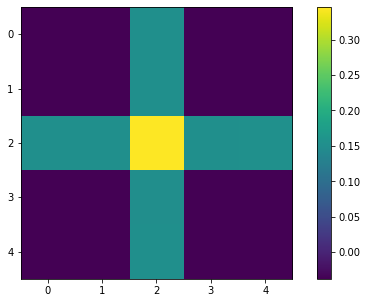

In [ ]:

plt.figure()
plt.imshow(np.squeeze(np.dot(decomp_kernels_fix[:, :, 0], np.squeeze(recomb_kernels_1))+np.dot(decomp_kernels_train[:, :, 0], np.squeeze(recomb_kernels_2))))
plt.colorbar()